# Проект - BigData_pySpark

### Описание:

В нашем распоряжении более 10 млн. записей о поездках такси в Чикаго и перед нами стоит задача предсказать количество заказов на следующий час в каждом округе. Решать ее мы будем с применением PySpark на локальном кластере из Docker контейнеров🐳

Для работы над проектом мы используем данные с  [Чикагского информационного портала](https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz) за август 2022 и 2023 гг.. В описании к данным сказано, что округлением времени происходит до 15 минут и в процессе предоставления данных сообщается не обо всех поездках такси по городу, но большинство поездок отражаются, возможно это связано с защитой конденфициальности или эти данные не относятся к городу, поэтому не фиксируются.

| №|Название столбцов|Описание| Тип данных с сайта|
|--|----------|----------|-------------|
|1|    Trip ID  |  Уникальный идентификатор поездки.  |   Text     |
|2|  Taxi ID    |  Уникальный идентификатор для такси.  |   Text     |
| 3|  Trip Start Timestamp   |  Когда началась поездка, округлено до ближайших 15 минут  |   Date & Time     |
| 4|    Trip End Timestamp |  Когда поездка закончилась, округлено до ближайших 15 минут.  |   Date & Time     |
| 5|    Trip Seconds |  Время поездки в секундах.  |   Number     |
| 6|    Trip Mile | Расстояние поездки в милях.   |    Number    |
| 7|    Pickup Census Tract |   Район, с которого началась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок. Для мест за пределами Чикаго этот столбец часто остается пустым. |    Text    |
| 8|   Dropoff Census Tract  |  Район, на котором завершилась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок. Для мест за пределами Чикаго этот столбец часто остается пустым.  |    Text    |
| 9|  Pickup Community Area   |  Район сообщества, с которого началась поездка. В этом столбце будут указаны места за пределами Чикаго. Пустыми будут указаны места за пределами Чикаго.  |   Number     | 
| 10| Dropoff Community Area    |  Район сообщества, где закончилась поездка. В этом столбце будут указаны места за пределами Чикаго. Пустым.  |    Number    | 
| 11|  Fare   |   Стоимость поездки. |   Number     | 
| 12|  Tips   |  Чаевые за поездку. Чаевые наличными, как правило, не учитываются.  |   Number     | 
| 13|   Tolls  |  Плата за поездку.  |   Number     | 
|14|    Extras  | Дополнительная плата за поездку.   |   Number     | 
|15| Trip Total     | Общая стоимость поездки, общая сумма по предыдущим столбцам.   |  Number      | 
|16|  Payment Type   |  Тип оплаты за поездку.  |    Text    | 
| 17|   Company  |  Таксомоторная компания.  |  Text      | 
| 18|   Pickup Centroid Latitude  |  Широта места или района сообщества, если участок переписи был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.  |     Number   | 
|19|    Pickup Centroid Longitude  | Долгота места или района сообщества, если участок переписи был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.   |    Number    | 
|20|  Pickup Centroid Location    |  Местоположение центра места или района Чикаго, если участок переписи был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.  |   Point     |
|21|  Dropoff Centroid Latitude    |  Широта   места высадки, если район Чикаго был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.  |    Number    | 
|22|   Dropoff Centroid Longitude   |  Долгота места, предназначенного для высадки, или района Чикаго, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.  |   Number     | 
|23|    Dropoff Centroid  Location  |   Местоположение центра места, предназначенного для высадки, или района Чикаго, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для мест за пределами Чикаго. |   Point     |

Установим PySpark и для ускорения работы PySpark будем использовать фреймворк Apache Arrow — это формат столбцов в памяти, используемый в Apache Spark для эффективной передачи данных между процессами Java и Python.

In [1]:
!pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 101.2 kB/s eta 0:00:00a 0:00:01


In [2]:
import pyspark.sql.functions as F
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
import numpy as np
import warnings

from pyspark.sql import SparkSession
from IPython.display import display, HTML
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from statsmodels.tsa.seasonal import seasonal_decompose
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from tqdm import tqdm
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
print(os.uname())

posix.uname_result(sysname='Linux', nodename='8b215fbbd27e', release='5.15.90.1-microsoft-standard-WSL2', version='#1 SMP Fri Jan 27 02:56:13 UTC 2023', machine='x86_64')


**Создаём сессию**

In [3]:
SPARK_MASTER_IP = '172.18.0.2'
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .getOrCreate()
spark

### Загрузка данных:

Пропишем сами типы данных, это позволит ускорить загрузку данных:

In [4]:
schema = StructType([
    StructField('Trip ID', StringType(), nullable=True),
    StructField('Taxi ID', StringType(), nullable=True),
    StructField('Trip Start Timestamp', StringType(), nullable=True),
    StructField('Trip End Timestamp', StringType(), nullable=True),
    StructField('Trip Seconds', IntegerType(), nullable=True),
    StructField('Trip Miles', FloatType(), nullable=True),
    StructField('Pickup Census Tract', StringType(), nullable=True),
    StructField('Dropoff Census Tract', StringType(), nullable=True),
    StructField('Pickup Community Area', IntegerType(), nullable=True),
    StructField('Dropoff Community Area', IntegerType(), nullable=True),
    StructField('Fare', FloatType(), nullable=True),
    StructField('Tips', FloatType(), nullable=True),
    StructField('Tolls', FloatType(), nullable=True),
    StructField('Extras', FloatType(), nullable=True),
    StructField('Trip Total', FloatType(), nullable=True),
    StructField('Payment Type', StringType(), nullable=True),
    StructField('Company', StringType(), nullable=True),
    StructField('Pickup Centroid Latitude', FloatType(), nullable=True),
    StructField('Pickup Centroid Longitude', FloatType(), nullable=True),
    StructField('Pickup Centroid Location', StringType(), nullable=True),
    StructField('Dropoff Centroid Latitude', FloatType(), nullable=True),
    StructField('Dropoff Centroid Longitude', FloatType(), nullable=True),
    StructField('Dropoff Centroid  Location', StringType(), nullable=True)
])

In [5]:
df_2022 = spark.read.csv('Taxi_Trips_-_2022.csv', header=True, schema=schema)

In [6]:
df_2022.count()

6382425

In [6]:
df_2023 = spark.read.csv('Taxi_Trips_-_2023.csv', header=True, schema=schema)

In [9]:
df_2023.count()

4337597

Соединим, для дальнейшей работы с ними, но статистики будем рассматривать отдельно, для меньшей ресурсозотратности процессов:

In [7]:
df = df_2022.union(df_2023)

In [10]:
df.columns

['Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Pickup Community Area',
 'Dropoff Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Payment Type',
 'Company',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Pickup Centroid Location',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid  Location']

In [12]:
HTML(df.limit(5).toPandas().to_html())

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,bcfa19f2539021c054809d4c3993d226996ae095,368ce5511598af2cc07efdb68067d381174fdac1d47a2837d021e647f4c8febb3d9bf330e155845b8217b9b451c29b1b9ecf5d55d4bfe6cfd5d79ffb49b1f334,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,152,0.10,NaN,NaN,NaN,NaN,3.75,0.00,0.0,0.0,3.75,Cash,Medallion Leasin,NaN,NaN,None,NaN,NaN,None
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,449fa4909552757130d09d98ebc7770e2dd94579036b0e1958f92577ffc9fd6deca97bc1f229d2700865ce12b54d454ba96f973077386210ccbe44bfb7aac317,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2360,17.44,NaN,NaN,NaN,8.0,47.75,0.00,0.0,5.0,52.75,Cash,Flash Cab,NaN,NaN,None,41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2,54d812a0b88f8f9707825261014b3563a0a60ace,f98ae5e71fdda8806710af321dce58002146886c013f411be2cd336e0c224e78ed85626eeee462f0d1f5e6b29a030514b95f7b1b8ca59888a10b52dfe55ddf99,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,536,4.83,NaN,NaN,28.0,22.0,14.75,0.00,0.0,0.0,14.75,Cash,Globe Taxi,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.922761,-87.699155,POINT (-87.6991553432 41.9227606205)
3,7125b9e03a0f16c2dfb5eaf73ed057dc51eb68ef,8eca35a570101ad24c638f1f43eecce9d0cb7843e13a75f0af0c911c3e31ddec549c4808e216bcf31634542025c1e7de2442b92d5d7d73463c4e05fd959e47b4,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,897,2.07,NaN,NaN,8.0,32.0,9.75,0.00,0.0,1.5,11.25,Cash,Sun Taxi,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
4,f1a650ee419b4e52d766432e6f86eca3457bfb37,e2d8418fcdb061eee0a4318fba0a6a1200aaff0143feb0a74c7175a02ec7afca09f8c24de278cd0dee124d29dbfb2796407d069b90dfc13353d5d4ed02ecb0d5,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2200,2.48,NaN,NaN,8.0,32.0,9.36,2.14,0.0,0.0,11.50,Mobile,Chicago Independents,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)


In [10]:
trip_count = df.count()
print('После объединения данных за 2022 и 2023 года мы имеем ', trip_count, 'поездку')

После объединения данных за 2022 и 2023 года мы имеем  10720022 поездку


### Изучим общую информацию:

Давайте посмотрим, какие колонки присутствуют в нашей таблице. Мы установливали параметр inferSchema=True и  pyspark самостоятельно определил типы для каждой колонки, сравним их с начальными типами, представленными на сайте[Чикагского информационного портала](https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz)

In [12]:
df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: float (nullable = true)
 |-- Pickup Census Tract: string (nullable = true)
 |-- Dropoff Census Tract: string (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Tips: float (nullable = true)
 |-- Tolls: float (nullable = true)
 |-- Extras: float (nullable = true)
 |-- Trip Total: float (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: float (nullable = true)
 |-- Pickup Centroid Longitude: float (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: float (nullable = true)
 |-- Dropoff Centroid Longi

Колонки с датой и  Point были распознаны pySpark как строки, для дальнейшей работы нам необходимо перевести колонку с датой в верный формат и тип datetime  и данные с Point будем использовать для работы с картами.

Для начала определимся с нужными признаками, которые помогут нам сделать оптимальный прогноз количества заказов на следующий час. Посмотрим на пропущенные значения в данных.

In [16]:
print('Количество пропущенных значений в столбцах составило:')
missing_counts = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns])
display(HTML(missing_counts.toPandas().to_html()))


print('Процентное соотношение пропусков в каждом столбце составило:')
missing_percentages = missing_counts.select(*((F.round(F.col(row) / trip_count * 100, 1)).alias(row) for row in missing_counts.columns))
HTML(missing_percentages.toPandas().to_html())

Количество пропущенных значений в столбцах составило:


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0,0,0,262,2283,70,6197810,6186985,697943,1051467,10329,10329,10329,10329,10329,0,0,694047,694047,694047,989262,989262,989262


Процентное соотношение пропусков в каждом столбце составило:


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0.0,0.0,0.0,0.0,0.0,0.0,57.8,57.7,6.5,9.8,0.1,0.1,0.1,0.1,0.1,0.0,0.0,6.5,6.5,6.5,9.2,9.2,9.2


Постепенно анализируя и визуализирую признаки мы будем заполнять пропуски, обосновывая своём решение

Большое количество пропусков содержат столбцы Pickup Census Tract и Dropoff Census Tract их около 6 млн. (57 %), остальные в пределах 10 % то общего количества поездок. 

### Oписательные статистики:

In [9]:
def statics(df, name):
    print('*' *50, name, '*' *50)
    print(df.select(F.min('Trip Start Timestamp')).show(truncate=False))
    print(df.select(F.max('Trip Start Timestamp')).show(truncate=False))
    print('Описательные статистики данных:')
    display(HTML(df.select(F.round(F.col('Trip Seconds'), 2), F.round(F.col('Trip Miles'), 2), \
                         F.round(F.col('Fare'), 2), F.round(F.col('Tips'), 2), F.round(F.col('Tolls')), \
                         F.round(F.col('Extras'), 2), F.round(F.col('Trip Total'), 2)).summary().toPandas().to_html()))

In [10]:
statics(df_2022, 'Taxi_Trips_-_2022')
statics(df_2023, 'Taxi_Trips_-_2023')

************************************************************ Taxi_Trips_-_2022 ************************************************************
+-------------------------+
|min(Trip Start Timestamp)|
+-------------------------+
|01/01/2022 01:00:00 AM   |
+-------------------------+

None
+-------------------------+
|max(Trip Start Timestamp)|
+-------------------------+
|12/31/2022 12:45:00 PM   |
+-------------------------+

None
Описательные статистики данных:


,summary,"round(Trip Seconds, 2)","round(Trip Miles, 2)","round(Fare, 2)","round(Tips, 2)","round(Tolls, 0)","round(Extras, 2)","round(Trip Total, 2)"
0,count,6380960,6382369,6378889,6378889,6378889,6378889,6378889
1,mean,1198.2085212883328,6.1855689058828665,21.72931311862629,2.7545550146994864,0.02148054308516734,2.163035586593336,26.825097613287003
2,stddev,1895.664878082732,8.002858369955094,49.41623912743541,4.083891670766789,7.659670679200717,21.75269212182083,56.96460438118927
3,min,0,0.0,0.0,0.0,0.0,0.0,0.0
4,25%,458,0.85,8.0,0.0,0.0,0.0,10.0
5,50%,862,2.6,14.0,0.92,0.0,0.0,17.0
6,75%,1620,11.1,33.25,4.0,0.0,2.0,40.5
7,max,86341,2967.54,9999.75,496.0,6667.0,8888.88,9999.75


************************************************************ Taxi_Trips_-_2023 ************************************************************
+-------------------------+
|min(Trip Start Timestamp)|
+-------------------------+
|01/01/2023 01:00:00 AM   |
+-------------------------+

None
+-------------------------+
|max(Trip Start Timestamp)|
+-------------------------+
|09/01/2023 12:00:00 AM   |
+-------------------------+

None
Описательные статистики данных:


,summary,"round(Trip Seconds, 2)","round(Trip Miles, 2)","round(Fare, 2)","round(Tips, 2)","round(Tolls, 0)","round(Extras, 2)","round(Trip Total, 2)"
0,count,4336779,4337583,4330804,4330804,4330804,4330804,4330804
1,mean,1233.7738897924012,6.4608845621912465,22.005239127456992,2.926593102195452,0.055032968474214024,2.2617615782509057,27.40796788475257
2,stddev,1726.1830498497168,7.631411496575405,21.83575879615507,4.21723416542611,12.419030450646408,19.338050807097503,37.280546920128
3,min,0,0.0,0.0,0.0,0.0,0.0,0.0
4,25%,477,0.93,8.25,0.0,0.0,0.0,10.13
5,50%,914,2.88,14.75,1.19,0.0,0.0,18.0
6,75%,1701,11.59,34.25,4.0,0.0,4.0,42.75
7,max,86382,945.4,9999.75,375.0,6667.0,9446.65,9999.75


Данные за 2022 и 2023 года отличаются по количеству данных, так как они собраны за разный промежуток времени, однако стоит заметить, что расчитанные показатели примерно остаются на сопоставимом друг от друга уровнях. 

### EDA

Данные с началом поездки распознаны  pySpark как тип стринг, исправим на тип datetime и формат времени AM и PM переведём вместо 12 часового формата в 24-х часовой и посмотрим действительно, за какой промежуток времени у нас есть данные.

In [11]:
# Преобразуем формат в timestamp и приведём к нужному формату

df = df.withColumn("trip_start_time", F.to_timestamp("Trip Start Timestamp", "MM/dd/yyyy h:mm:ss a"))\
       .withColumn("trip_stop_time", F.to_timestamp("Trip End Timestamp", "MM/dd/yyyy h:mm:ss a"))


In [12]:
df.select('trip_start_time', 'trip_stop_time').printSchema()

root
 |-- trip_start_time: timestamp (nullable = true)
 |-- trip_stop_time: timestamp (nullable = true)



Теперь, после отсортируем наши данные по районам и датам, для дальнейшей работы с ними:

In [12]:
df = df.orderBy(F.col('Pickup Community Area'), F.col('trip_start_time'))

Данные о переписном участке с которого началась поездка и завершилась также не будем использовать, так как он не информативен и имеет большое количество пропусков в данных и удалим столбцы с началом поездки и конца с типами стринг.

In [13]:
df = df.drop(F.col("Trip Start Timestamp"), F.col("Trip End Timestamp"), F.col("Pickup Census Tract"), \
        F.col("Dropoff Census Tract")) 

In [12]:
df.select(F.min('trip_start_time'),F.max('trip_start_time')).show()
df.select(F.min('trip_stop_time'),F.max('trip_stop_time')).show()

+--------------------+--------------------+
|min(trip_start_time)|max(trip_start_time)|
+--------------------+--------------------+
| 2022-01-01 00:00:00| 2023-09-01 00:00:00|
+--------------------+--------------------+

+-------------------+-------------------+
|min(trip_stop_time)|max(trip_stop_time)|
+-------------------+-------------------+
|2003-02-11 17:45:00|2023-09-04 17:45:00|
+-------------------+-------------------+



После приведения даты в нужный тип,  мы видим, что данные с началом поездки у нас есть с 1 января 2022 года по 1 сентября 2023 года. В данных по столбцу с окончанием поездки попали данные с 2003 года, что говорит скорее всего об ошибке в заполнении. Также если смотреть на максимальную дату начала и конца поездки можно заметить разницу в 3,5 дня, возможно это различие связано с тем, что начало поездки могло начаться за пределами штата Чикаго, а эти данные как мы знаем они не фиксируют, так как находятся под защитой конденфициальности. Для дальнейшей работы и предсказания количества такси нам потребуется только столбец с началом поездки, поэтому мы считаем, что обрабатывать и искать причину искажения данных в столбце с концом поездки не целесообразно.

Для выведения графиков и отрисовки карт, данных в основной таблице слишком, много, поэтому будем использовать выборку со случайно отобранными заказами, чтобы получить примерное представление о заказах и не исказить информацию. Данные будем использовать за 2022 год, так как при использовании общей таблицы мы получим большую разницу в случайно отобранных данных

In [26]:
df_analiz = df.sample(False, 0.02, 42)
# создадим таблицу pandas для визуализации данных
df_analiz_pandas = df_analiz.toPandas()

In [18]:
analiz_count = df_analiz.count()
print('Количество заказов в выборке: ', analiz_count)

Количество заказов в выборке:  215016


Посмотрим на диаграммы размаха до того, как будем более подробно анализировать столбцы, чтобы иметь представление о данных, кроме описательных статистик.

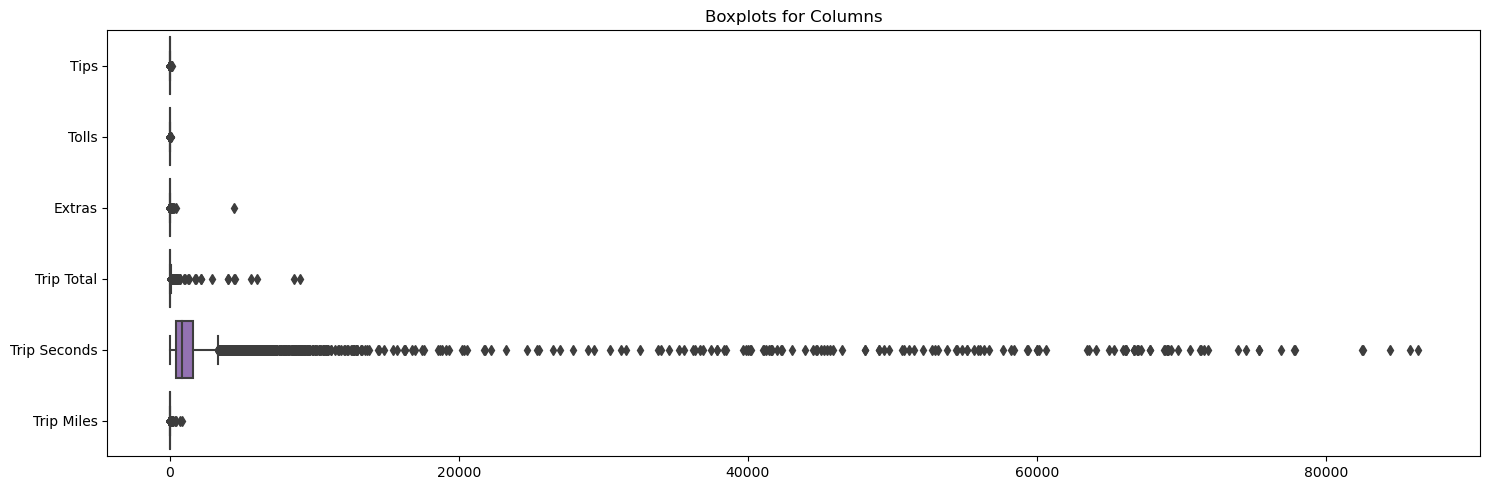

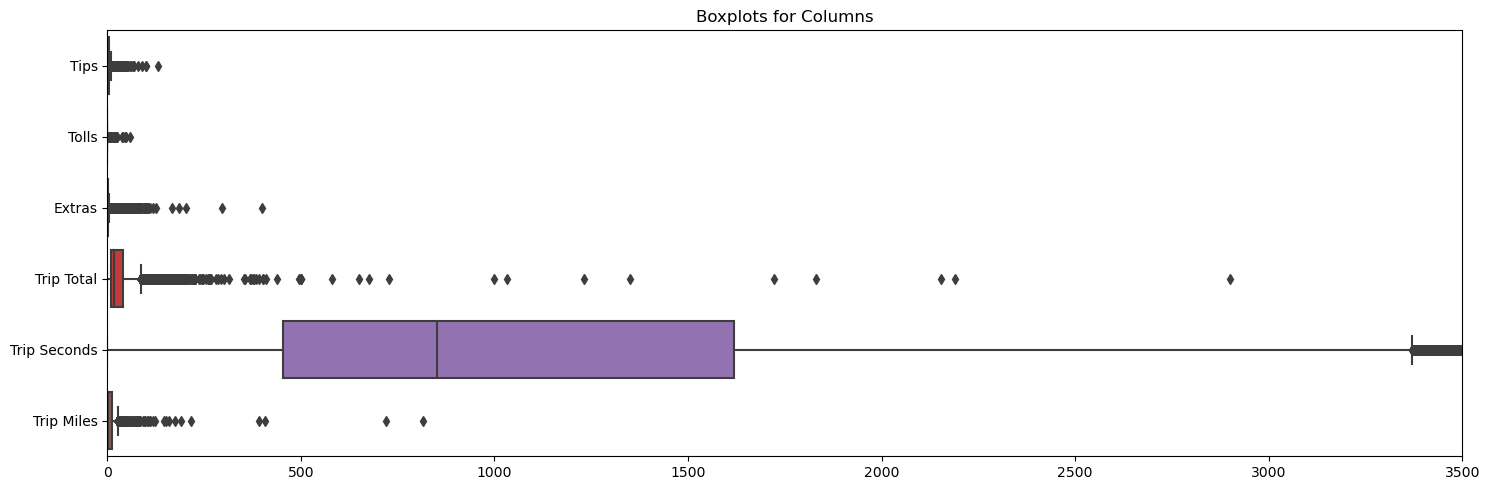

In [77]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df_analiz_pandas[['Tips','Tolls','Extras','Trip Total','Trip Seconds','Trip Miles']], orient='h')
plt.title('Boxplots for Columns')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(data=df_analiz_pandas[['Tips','Tolls','Extras','Trip Total','Trip Seconds','Trip Miles']], orient='h')
plt.xlim(0, 3500)
plt.title('Boxplots for Columns')
plt.tight_layout()
plt.show()

Выбросы имеют все данные, самый большой по колонке со временем поездки в секундах, они более 80тыс. что примерно составляет более 22 часов в дороге. Эти заказы уникальны и их не так много в данных, возможно это ошибка, возможно нет, так как по колонке с полной стоимостью поездки имеются такие же большие выбросы.

### Trip ID:

In [104]:
print('Общее количество заказов: ', trip_count)
print('Количество уникальных индентификаторов такси: ')
df.select(F.countDistinct('Trip ID')).show()

Общее количество заказов:  10720022
+-----------------------+
|count(DISTINCT Trip ID)|
+-----------------------+
|               10720022|
+-----------------------+



Индентификаторы поездок уникальны во всей таблице

### Taxi ID

In [31]:
print('Количество уникальных индефикаторов такси составило: ', df_analiz.select('Taxi ID').distinct().count(), 'машин')

Количество уникальных индефикаторов такси составило:  2834 машин


In [20]:
df_analiz.groupBy('Taxi ID').agg(F.count('Taxi ID').alias('count_trip'), \
                          F.sum('Trip Seconds').alias('sum_seconds'), \
                          F.round(F.sum('Trip Miles')).alias('sum_miles'), \
                          F.countDistinct('Pickup Community Area').alias('max_start_area'), \
                          F.countDistinct('Dropoff Community Area').alias('max_stop_area'), \
                          F.round(F.sum('Trip Total')).alias('trip_total'), \
                          F.countDistinct('Company').alias('company')).orderBy(F.col('count_trip').desc()).show(15)

+--------------------+----------+-----------+---------+--------------+-------------+----------+-------+
|             Taxi ID|count_trip|sum_seconds|sum_miles|max_start_area|max_stop_area|trip_total|company|
+--------------------+----------+-----------+---------+--------------+-------------+----------+-------+
|2780ead18beaa862c...|       295|     286641|   1111.0|            22|           27|    5457.0|      1|
|f98ae5e71fdda8806...|       262|     223815|   1140.0|            20|           28|    4815.0|      1|
|a79d72d3d49bed135...|       258|     273645|   2577.0|            50|           43|    7093.0|      1|
|3b084cc9045b3afc1...|       257|     200021|    745.0|            17|           23|    3559.0|      1|
|5bee5f6487e84f44c...|       256|     178680|   1148.0|            19|           28|    4057.0|      1|
|14685d7c19b1bcf05...|       247|     209940|   1388.0|            40|           41|    5384.0|      1|
|6c862bc95ea06a072...|       239|     267301|   1803.0|         

Выборка используется не большая в сравнении с основной, но основную информацию мы видим. Такси имеют примерно одинаковое количество принятых заказов, некоторые в зависимости от пройденного растояния имеют соответствующее общее время поезок и стоимость. Таксисты бывают в десятках районов, они не привязаны к каким-то определённым места в штатах. В основном такси работает на одну компанию (например: у компании есть свой таксопарк), но не всегда, есть и несколько, предположительно это люди владеющие личным транспортом и оказывающие услуги для нескольких компаний.

### Матрица корреляции:

In [21]:
df_analiz.select(F.col('Trip Miles'), F.col('Pickup Community Area'), F.col('Dropoff Community Area'), \
                 F.col('Fare'), F.col('Tips'), F.col('Tolls'), F.col('Extras'), \
                 F.col('Trip Total')).toPandas().corr(numeric_only=True).style.background_gradient(cmap ='YlOrRd')

,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total
Trip Miles,1.000000,0.415292,0.184008,0.285761,0.401409,-0.000916,0.093342,0.295436
Pickup Community Area,0.415292,1.000000,0.101997,0.192829,0.376195,-0.000955,0.105886,0.220666
Dropoff Community Area,0.184008,0.101997,1.000000,0.090449,0.066298,-0.000965,0.000014,0.078309
Fare,0.285761,0.192829,0.090449,1.000000,0.189859,-0.000208,0.043842,0.840865
Tips,0.401409,0.376195,0.066298,0.189859,1.000000,-0.000496,0.107540,0.268906
Tolls,-0.000916,-0.000955,-0.000965,-0.000208,-0.000496,1.000000,0.526217,0.439265
Extras,0.093342,0.105886,0.000014,0.043842,0.107540,0.526217,1.000000,0.528643
Trip Total,0.295436,0.220666,0.078309,0.840865,0.268906,0.439265,0.528643,1.000000


Высокая корреляция наблюдается между общей стоимостью поездки и стоимостью поездки, так как она составляет основную долю платы за проезд (+чаевые, с корреляцией в 0,26). Стоимость зависит от миль, что и логично. Также наблюдается связь между милями, районами и чаевыми, предположительно чем больше расстояние тем вернее таксист получит чаевые или здесь может быть разница в местоположении районов, например нахождении в них рабочих зон, торговых центров и д.р. 

### Районы:

 Посмотрим какие районы сообщества пользуются популярностью, нанесём на карту данные, где начиналась и заканчивалась поездка. Убедимся, что количество районов в этих данных совпадают

In [22]:
df_analiz.select('Pickup Community Area', 'Dropoff Community Area').distinct().orderBy(F.col('Pickup Community Area').desc(),\
 F.col('Dropoff Community Area').desc()).show(1)

+---------------------+----------------------+
|Pickup Community Area|Dropoff Community Area|
+---------------------+----------------------+
|                   77|                    77|
+---------------------+----------------------+
only showing top 1 row



Участков 77 на территории таксомоторных компаний, совпадение максимальных районов говорит нам о правильности заполнения поездок, в колонках нет не корректно заполненных данных. Для наглядности расположения участков обратимся к карте ![Чикаго](https://image.jimcdn.com/app/cms/image/transf/none/path/s2d70f809eb13ec87/image/i6b5aec75226ae805/version/1486095039/image.jpg)

Заполним пропуски в районах нулями (и в основной таблице и в таблице для EDA), так как у нас есть районы за пределами штата

In [17]:
df_analiz = df_analiz.na.fill(value=0,subset=['Pickup Community Area', 'Dropoff Community Area'])
df = df.na.fill(value=0,subset=['Pickup Community Area', 'Dropoff Community Area'])

In [24]:
df_analiz.groupBy('Pickup Community Area').count().orderBy(F.col('count').desc()).show(5)
df_analiz.groupBy('Dropoff Community Area').count().orderBy(F.col('count').desc()).show(5)

+---------------------+-----+
|Pickup Community Area|count|
+---------------------+-----+
|                    8|48505|
|                   76|37035|
|                   32|34822|
|                   28|18523|
|                    0|14120|
+---------------------+-----+
only showing top 5 rows

+----------------------+-----+
|Dropoff Community Area|count|
+----------------------+-----+
|                     8|49792|
|                    32|32886|
|                     0|21181|
|                    28|19258|
|                    76|11849|
+----------------------+-----+
only showing top 5 rows



Заказы часто поступают из 8 и 32 районов, они распологаются рядом с друг другом, и если посмотреть Яндекс карты Чикаго, то мы видим, что это районы где распологается зона развлечений и отдыха (например: многочисленные музеи, мемориалы, парки, скверы, лесопарки, планетарий, возможно проводятся экскурсии по воде, так как эти районы расположены на берегу оз.Мичиган, предположительно и корреляция между чаевыми и этими районами повлияла на показатели).  Достаточно большое количество  заказов поступают из 76, 28 и районов расположенных за пределами штата. Такая же ситуация и по районам, в которых происходила высадка пассажиров, только данных по не зафиксированных районам больше.

In [18]:
df_analiz.select('Pickup Centroid Location', 'Dropoff Centroid  Location').show(10, truncate=False)

+------------------------+------------------------------------+
|Pickup Centroid Location|Dropoff Centroid  Location          |
+------------------------+------------------------------------+
|null                    |null                                |
|null                    |null                                |
|null                    |null                                |
|null                    |null                                |
|null                    |null                                |
|null                    |POINT (-87.6559981815 41.9442266014)|
|null                    |POINT (-87.6023504372 41.8237128095)|
|null                    |null                                |
|null                    |POINT (-87.6262149064 41.8925077809)|
|null                    |null                                |
+------------------------+------------------------------------+
only showing top 10 rows



Так как координата широты представлена ​​как -87.6635175498 в десятичных градусах, мы могли бы округлить и сохранить до 6 знаков после запятой для точности 10 см (или 0.1 метра), до 5 знаков это 1,11 м., либо до 4 - 11,06 м.  Для дальнейшего анализа нам не так важны очень точные координаты, но так как мы будем использовать долготу и широту, то там данные округлены до 6 знака, что примерно составляет смещение на 11 см. Для обоснования решения приведём таблицу, первый столбец показывает количество знаков после запятой, последний показывает на сколько идёт округление если отбрасывать остальную часть после знака.

|Десятичные числа|	Десятичные градусы|	Расстояние (метры)|
|----|----|-----|
| 0    |  1.0   |110 км 574 м 3  см     |
|1     |    0.1 |11 км 57 м 43  см   |
| 2    |   0.01  |1 км 105 м 74см     |
|  3   |   0.001  | 110 м 57 см    |
|   4  |   0.0001  |11 м 6 см    |
|   5  |  0.00001   | 1м 11 см   |
|   6  |   0.000001  |  11 см   |
|  7   |   0.0000001  |  1 см   |
|  8   |   0.00000001  |  1 мм   |.001	1 мм

Для расчёта координат очистим данные от пропущенных значений, они занимают не так много данных

In [20]:
df_maps = df_analiz_pandas[['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude',
                            'Dropoff Centroid Longitude']]
df_maps.dropna(inplace=True)

In [21]:
df_maps.head(5)

,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
287,41.982777,-87.877304,41.982777,-87.877304
704,41.982777,-87.877304,41.982777,-87.877304
916,41.982777,-87.877304,41.982777,-87.877304
950,41.982777,-87.877304,41.982777,-87.877304
1152,41.982777,-87.877304,41.982777,-87.877304


Нанесём точки посадки и высадки на карту,чтобы посмотреть концентрацию визуально (операции с отрисовкой координат достаточно энергоёмкие, поэтому прикрепляем скриншоты)

Точки на карту можно нанести сразу все, то тогда создаётся наплыв их одна на другую и не видна картина концентрации заказов. Нанесём их по отдельности

In [25]:
# Создаем карту
map = folium.Map(location=[41.9828, -87.8773])

# Наносим красные точки забора клиента на карту
for row in df_maps[:10000].iterrows():
    start_location = [row[1]['Pickup Centroid Latitude'], row[1]['Pickup Centroid Longitude']]
    folium.Marker(location=start_location, icon=folium.Icon(color='red', icon_size=(20, 20))).add_to(map)

# Выводим карту
map

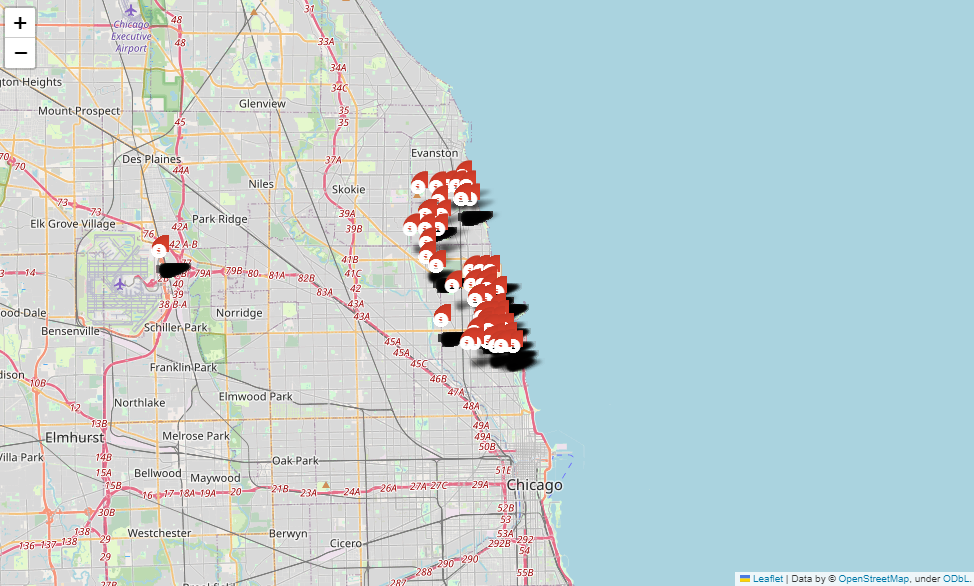

In [23]:
# Создаем карту
map = folium.Map(location=[41.9828, -87.8773])

# Наносим синие точки высадки клиента на карту
for row in df_maps[:10000].iterrows():
    stop_location = [row[1]['Dropoff Centroid Latitude'], row[1]['Dropoff Centroid Longitude']]
    folium.Marker(location=stop_location, icon=folium.Icon(color='blue', icon_size=(20, 20))).add_to(map)

# Выводим карту
map

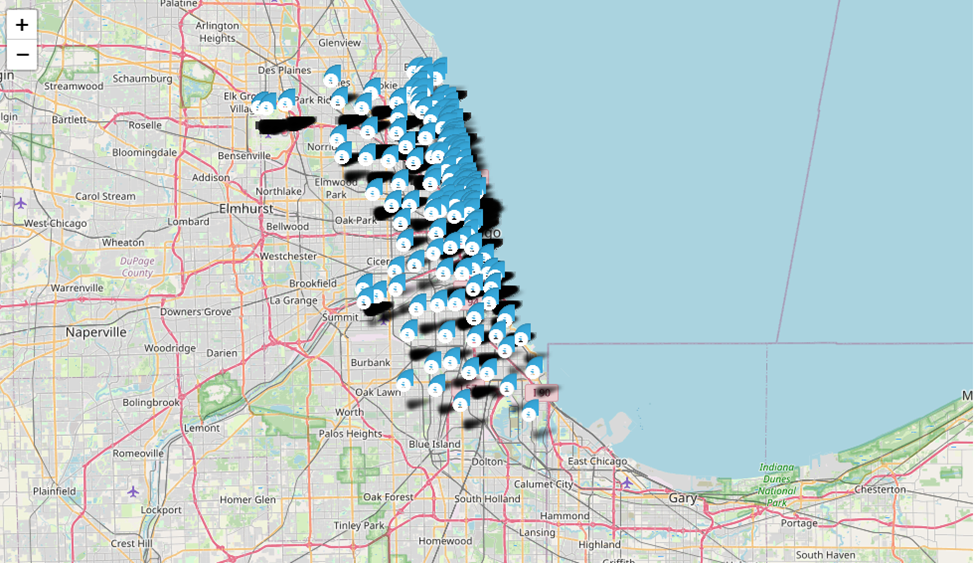

Вывод: Как и описанные данные выше по районам, мы только лишь визуально изобразили концентрацию заказов. Красными точками на карте отмечены точки посадки пассажиров, синими - точки высадки.

Убедимся на основе начальной таблицы, что тенденция с распределением количества заказов по районам такая же как и в данных для анализа.

In [13]:
df.groupBy('Pickup Community Area').count().orderBy(F.col('count').desc()).show(5)
df.groupBy('Dropoff Community Area').count().orderBy(F.col('count').desc()).show(5)

+---------------------+-------+
|Pickup Community Area|  count|
+---------------------+-------+
|                    8|2422217|
|                   76|1851958|
|                   32|1733617|
|                   28| 925887|
|                    0| 697943|
+---------------------+-------+
only showing top 5 rows

+----------------------+-------+
|Dropoff Community Area|  count|
+----------------------+-------+
|                     8|2476325|
|                    32|1652725|
|                     0|1051467|
|                    28| 958704|
|                    76| 591625|
+----------------------+-------+
only showing top 5 rows



Наблюдения с 0-ми регионами мы не будем использовать в нашем предсказании, поэтому мы их удалим

In [15]:
df = df.filter((df['Pickup Community Area'] != 0))

### Company:

Выведем компании, которые наиболее часто предоставляют свои услуги по перевозке.

In [69]:
print('Количество компаний в Чикаго составило', df.select(F.col('Company')).distinct().count())
df_analiz.groupBy('Company').agg(F.count('Trip ID').alias('count_trip'), \
                          F.countDistinct('Taxi ID').alias('count_taxi'),\
                          F.countDistinct('Pickup Community Area').alias('max_area'), \
                          F.round(F.sum('Fare'))).orderBy(F.col('count_trip').desc()).show(10, truncate=False)

Количество компаний в Чикаго составило 43
+-----------------------------+----------+----------+--------+-------------------+
|Company                      |count_trip|count_taxi|max_area|round(sum(Fare), 0)|
+-----------------------------+----------+----------+--------+-------------------+
|Flash Cab                    |28117     |555       |78      |613001.0           |
|Taxi Affiliation Services    |26628     |534       |78      |540333.0           |
|Sun Taxi                     |14488     |304       |69      |310580.0           |
|City Service                 |11725     |275       |73      |249995.0           |
|Chicago Independents         |6431      |193       |43      |137712.0           |
|Taxicab Insurance Agency Llc |5578      |217       |49      |115781.0           |
|Medallion Leasin             |5367      |136       |63      |112387.0           |
|Taxicab Insurance Agency, LLC|5291      |183       |51      |119174.0           |
|Globe Taxi                   |4939      |112

Такие компании как Flash Cab и Taxi Affiliation Services имеют большее количество машин для оказания услуг, соответственно у них и большее число осуществленных поездок и полученной прибыли. Дополнительно мы вывели количество уникальных районов по каждой компании и показатели говорят нам, что они все действуют во всех районах Чикаго, привязки к определённым районам нет.

### Trip  and card:

In [71]:
print('Количество поездок в выборке: ', df_analiz.count())
print('Количество поездок, когда таксист получал чаевые составило: ', df_analiz.filter(F.col('Tips') != 0).count())

Количество поездок в выборке:  127663
Количество поездок, когда таксист получал чаевые составило:  64502


Почти в половине случаев таксисту дают чаевые

In [72]:
print('Не отображена стоимость поездки в ', df_analiz.filter(F.col('Fare') == 0.0).count(), 'случаях')

Не отображена стоимость поездки в  130 случаях


In [94]:
print('Нулевые показатели платы за поездку составили: ', round((df_analiz.filter(F.col('Tolls') == 0.0).count() / df_analiz.count())*100, 2), \
      '% . Для нас этот столбец не информативен, поэтому в анализе его не будем использовать')

Нулевые показатели платы за поездку составили:  99.75 % . Для нас этот столбец не информативен, поэтому в анализе его не будем использовать


Подробнее посмотрим на способы оплаты поездки, какой тип оплаты преобладает и проходимая сумма в разрезе каждого типа:

In [78]:
df_analiz.groupBy('Payment Type').agg(F.count('Payment Type').alias('count'), \
                               F.round(F.sum('Fare')), \
                               F.round(F.sum('Trip Miles')).alias('sum_miles'), 
                               F.round((F.sum('Trip Seconds')/3600)).alias('sum_hour'), \
                               F.round(F.sum('Trip Total')).alias('sum_trip_total'), \
                               F.countDistinct('Company')).alias('company').orderBy(F.col('count').desc()).show()

+------------+-----+-------------------+---------+--------+--------------+--------------+
|Payment Type|count|round(sum(Fare), 0)|sum_miles|sum_hour|sum_trip_total|count(Company)|
+------------+-----+-------------------+---------+--------+--------------+--------------+
| Credit Card|49714|          1301249.0| 408062.0| 18652.0|     1797489.0|            34|
|        Cash|41651|           746602.0| 185952.0| 12200.0|      818078.0|            34|
|      Mobile|18366|           287933.0|  65094.0|  4486.0|      352202.0|            18|
|      Prcard|11722|           287712.0|  96222.0|  4918.0|      291081.0|            17|
|     Unknown| 6087|           137917.0|  29383.0|  2247.0|      138584.0|            13|
|   No Charge|   72|             1753.0|    404.0|    21.0|        2133.0|             6|
|     Dispute|   51|              943.0|    263.0|    13.0|        1137.0|             8|
+------------+-----+-------------------+---------+--------+--------------+--------------+



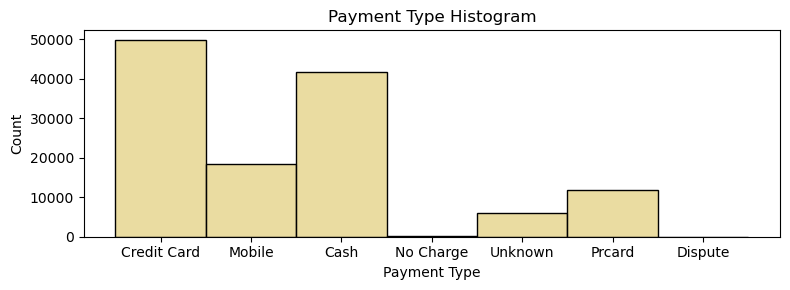

In [94]:
plt.figure(figsize=(8, 3))
sns.histplot(data=df_analiz_pandas, x='Payment Type', discrete=True, color='#E3D182')

plt.title('Payment Type Histogram')
plt.xlabel('Payment Type')

plt.tight_layout()
plt.show()

Большой популярностью пользуются кредитные карты и наличные. Далее переводы и [Prcard](https://en.wikipedia.org/wiki/Canada_permanent_resident_card) карта постоянного жителя (PR card; французский: carte de résident permanent) -  проездной документ для постоянных жителей Канады, которым жители часто пользуются особенно иммигранты. Есть не зафиксированные способы оплаты, бесплатные и спорные, которые возможно сотруднику пришлось возмещать самому для компании из-за различных обстоятельств.

### Time: Графики

In [78]:
df_select = df.groupBy(F.date_trunc('hour', F.col('trip_start_time')).alias('trip_start_time')).agg(F.count('Trip ID').alias('trip_id_count'))\
                                                    .orderBy(F.col('trip_start_time'))

Построим график зависимости заказов такси по дням и часам

In [79]:
df_select.columns

['trip_start_time', 'trip_id_count']

In [38]:
Построим график зависимости заказов такси по дням и часам

In [27]:
df_pd = df_select.toPandas() 
df_pd.set_index("trip_start_time", inplace=True)

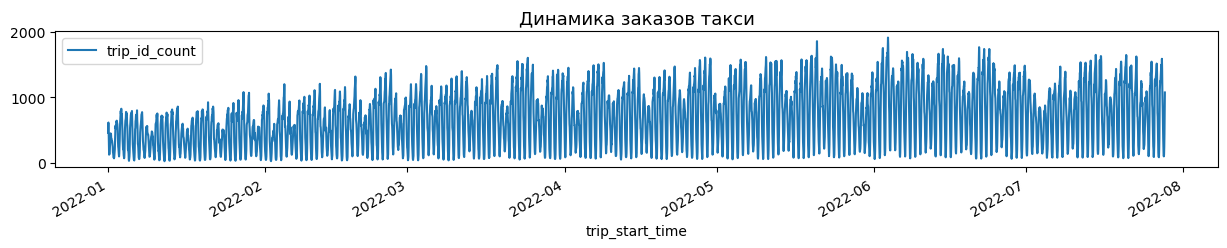

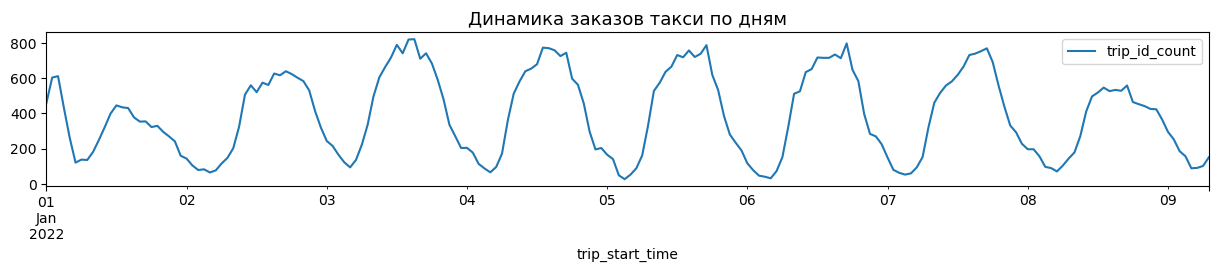

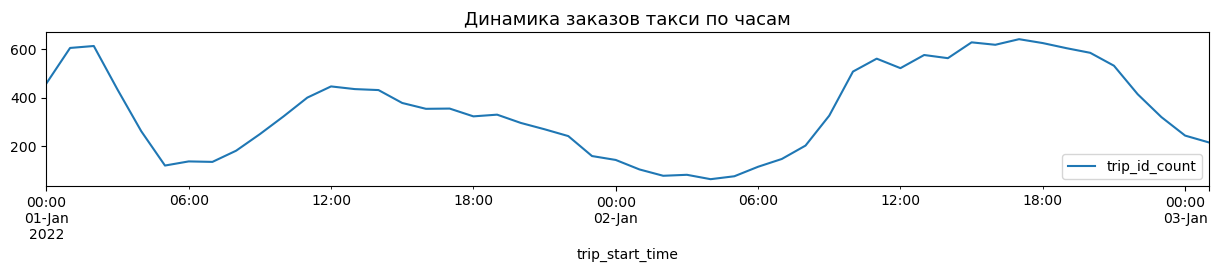

In [82]:
df_pd[:5000].plot(y="trip_id_count", use_index=True, figsize=(15, 2))
plt.title('Динамика заказов такси', fontsize=13);
df_pd[:200].plot(y="trip_id_count", use_index=True, figsize=(15, 2))
plt.title('Динамика заказов такси по дням', fontsize=13);
df_pd[:50].plot(y="trip_id_count", use_index=True, figsize=(15, 2))
plt.title('Динамика заказов такси по часам', fontsize=13);


In [83]:
df_pd[df_pd['trip_id_count'] > 1800].head(10)

,trip_id_count
trip_start_time,
2022-05-20 18:00:00,1854
2022-06-03 18:00:00,1909
2022-06-03 19:00:00,1809
2022-08-19 18:00:00,1811
2022-09-14 14:00:00,1827
2022-09-14 17:00:00,1847
2022-09-14 18:00:00,1833
2022-09-15 17:00:00,1804
2022-09-15 18:00:00,1819


Основная нагрузка по заказам такси приходится на вечернее время

Выведем графики сезонности, треда, шума, и отобразим скользящую среднюю, предварительно сделав ресемплинг в 1 день

In [89]:
df_pd = df_pd.resample('1D').sum()
decomposed = seasonal_decompose(df_pd['trip_id_count'])

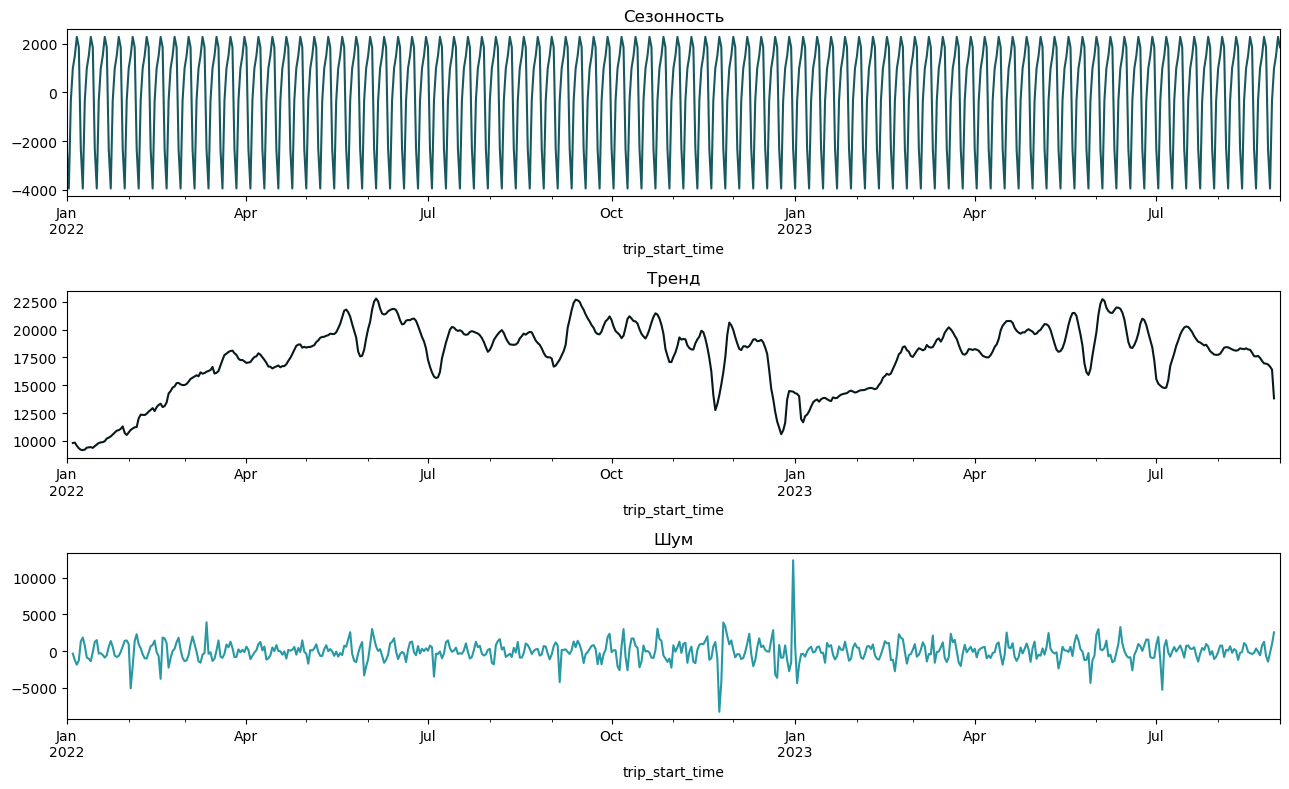

In [100]:
plt.figure(figsize=(13, 8))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca(), color='#18595f')
plt.title('Сезонность')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca(), color='#07191b')
plt.title('Тренд')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='#2899a4')
plt.title('Шум')
plt.tight_layout()
plt.show();

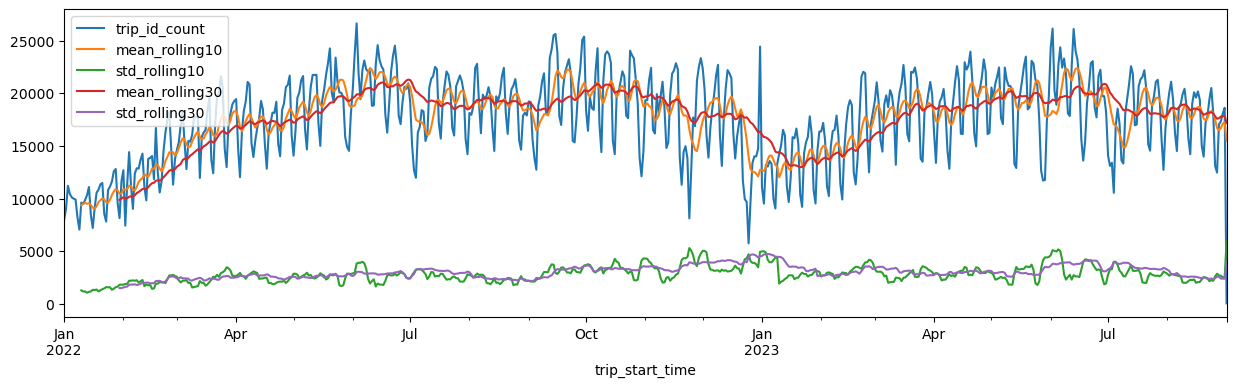

In [92]:
df_pd['mean_rolling_10'] = df_pd['trip_id_count'].rolling(10).mean()
df_pd['std_rolling_10'] = df_pd['trip_id_count'].rolling(10).std()
df_pd['mean_rolling_20'] = df_pd['trip_id_count'].rolling(20).mean()
df_pd['std_rolling_20'] = df_pd['trip_id_count'].rolling(20).std()
df_pd.plot(figsize=(15,4))
plt.show();

Мы видим, что временной ряд не стационарен. Если посмотреть на график динамики заказов по месяцам, видно небольшое увеличение, это может быть связано с сезонностью (летнее время). Пик заказов такси наблюдается в вечернее время в районе 17-19 часов.

### Подготовка данных для обучения

Отберём необходимые нам признаки:

In [8]:
df_sample = df.alias('df_sample')

Заменим названия колонок на строчные буквы и заменим все пробелы

In [9]:
for col in df_sample.columns:
    df_sample = df_sample.withColumnRenamed(col, col.lower().replace(' ', '_'))
df_sample = df_sample.na.drop(subset=["pickup_community_area"])

Оставим только необходимые колонки:

In [10]:
df_selection = df_sample.select('trip_start_timestamp', 'trip_seconds', 'trip_miles', 'pickup_community_area', 'fare', 'tips', 'extras', 'taxi_id', 'payment_type', 'company')
df_selection = df_selection.withColumn('trip_start_timestamp', F.to_timestamp(F.col('trip_start_timestamp'),'MM/dd/yyyy hh:mm:ss a'))
# Добавляем столбец 'percent_rank'
df_selection = df_selection.withColumn('percent_rank', F.percent_rank().over(Window.orderBy('trip_start_timestamp')))

Удалим строки, где длительность поездки ('Trip Seconds') равна нулю, но расстояние поездки ('Trip Miles') не равно нулю. Такие записи, вероятно, являются некорректными, так как не может быть поездки с нулевой длительностью и ненулевым расстоянием. Также удаляемя строки, где и длительность поездки ('Trip Seconds') и расстояние поездки ('Trip Miles') равны нулю. Это также может быть некорректными данными, так как они указывают на поездку без движения (нулевое расстояние) и без времени (нулевая длительность), что скорее всего является ошибкой или аномалией в данных.

In [11]:
df_selection = df_selection.filter(~((F.col('Trip Seconds') == 0) & (F.col('Trip Miles') == 0)))
df_selection = df_selection.filter(~((F.col('Trip Seconds') == 0) & (F.col('Trip Miles') != 0)))
df_selection = df_selection.dropna()

In [12]:
# Фильтруем данные для тренировочного набора
df_train = df_selection.filter("percent_rank <= 0.6").drop('percent_rank')

# Фильтруем данные для валидационного набора
df_valid = df_selection.filter("percent_rank > 0.6 AND percent_rank <= 0.8").drop('percent_rank')

# Фильтруем данные для тестового набора
df_test = df_selection.filter("percent_rank > 0.8").drop('percent_rank')

In [13]:
df_train.show(5)

+--------------------+------------+----------+---------------------+-----+----+------+--------------------+------------+--------------------+
|trip_start_timestamp|trip_seconds|trip_miles|pickup_community_area| fare|tips|extras|             taxi_id|payment_type|             company|
+--------------------+------------+----------+---------------------+-----+----+------+--------------------+------------+--------------------+
| 2022-01-01 00:00:00|         536|      4.83|                   28|14.75| 0.0|   0.0|f98ae5e71fdda8806...|        Cash|          Globe Taxi|
| 2022-01-01 00:00:00|         897|      2.07|                    8| 9.75| 0.0|   1.5|8eca35a570101ad24...|        Cash|            Sun Taxi|
| 2022-01-01 00:00:00|        2200|      2.48|                    8| 9.36|2.14|   0.0|e2d8418fcdb061eee...|      Mobile|Chicago Independents|
| 2022-01-01 00:00:00|        1256|     13.29|                   76| 34.0| 0.0|   6.0|b9a58663518c48b09...|        Cash|        City Service|
| 2022

In [17]:
df_train.columns

['trip_start_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_community_area',
 'fare',
 'tips',
 'extras',
 'taxi_id',
 'payment_type',
 'company']

После разделения данных напишем функцию, для часовой агрегации данных о заказах

In [15]:
def data_region_agg(data, region):

    data = data.filter(F.col('pickup_community_area') == region).drop('pickup_community_area')\
    .groupBy(F.date_trunc('hour', 'trip_start_timestamp').alias('time')) \
        .agg(F.count('*').alias('target'),
             F.countDistinct('taxi_id').alias('taxi_distinct'),
             F.avg('trip_seconds').alias('trip_seconds_avg'),
             F.avg('trip_miles').alias('trip_miles_avg'),
             F.avg('fare').alias('fare_avg'),
             F.avg('tips').alias('tips_avg'), 
             F.avg('extras').alias('extras_avg'),
             F.countDistinct('payment_type').alias('payment_type_distinct'),
             F.countDistinct('company').alias('company_distinct')).sort('time', ascending=True)
    return data

Дополним наши выборки дополнительными признаками

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    lag_window = Window.orderBy('time')
    mean_window = Window.orderBy('time').rowsBetween(-1 - rolling_mean_size,-1)
    
    data = (data.withColumn('day_of_month', F.dayofmonth('time'))
            .withColumn('day_of_year', F.dayofyear('time'))
            .withColumn('month', F.month('time'))
            .withColumn('week_no', F.weekofyear('time'))
            .withColumn('day_of_week', F.dayofweek(F.col('time'))))
    #data = data.withColumn('unix_ts', F.unix_timestamp('trip_start_timestamp'))
    
    for lag in range(1, max_lag + 1):
        data = data.withColumn('lag_{}'.format(lag), F.lag('target', lag).over(lag_window))
    data = data.withColumn('lag_week', F.lag('target', 7 * 24).over(lag_window))
    data = data.withColumn('rolling_mean_{}'.format(rolling_mean_size), F.avg('target').over(mean_window))
    data = data.dropna()
    return data

In [15]:
# Список регионов
regions = list(range(1, 78))

In [16]:
# Итерирование по таблицам и регионам
for part in ['df_train', 'df_valid', 'df_test']:
    for region in tqdm(regions):
        # Получение имени таблицы
        table_name = f'{part}_{region}'
        # Сортировка и применение функций к данным:
        globals()[table_name] = make_features(data_region_agg(globals()[part]\
                                            .sort('trip_start_timestamp'), region), 24, 24)\
                                            .cache()

100%|██████████| 77/77 [00:34<00:00,  2.26it/s]


In [19]:
HTML(df_train_1.limit(5).toPandas().to_html())

,time,target,taxi_distinct,trip_seconds_avg,trip_miles_avg,fare_avg,tips_avg,extras_avg,payment_type_distinct,company_distinct,day_of_month,day_of_year,month,week_no,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_week,rolling_mean_24
0,2022-01-08 19:00:00,3,3,1596.333333,9.836666,27.416667,2.616667,1.333333,3,3,8,8,1,1,7,2,3,3,11,7,8,8,11,8,2,1,3,3,1,2,2,1,1,2,2,1,5,4,3,1,3.88
1,2022-01-08 20:00:00,3,3,1384.333333,2.170000,18.833333,0.000000,0.000000,3,2,8,8,1,1,7,3,2,3,3,11,7,8,8,11,8,2,1,3,3,1,2,2,1,1,2,2,1,5,4,2,3.88
2,2022-01-08 21:00:00,3,3,1340.000000,8.733333,24.416667,0.000000,0.000000,2,1,8,8,1,1,7,3,3,2,3,3,11,7,8,8,11,8,2,1,3,3,1,2,2,1,1,2,2,1,5,3,3.88
3,2022-01-08 22:00:00,2,2,2683.000000,10.295000,40.375000,0.000000,0.000000,2,2,8,8,1,1,7,3,3,3,2,3,3,11,7,8,8,11,8,2,1,3,3,1,2,2,1,1,2,2,1,5,3.84
4,2022-01-08 23:00:00,3,2,580.333333,1.703333,8.416667,0.000000,0.000000,2,1,8,8,1,1,7,2,3,3,3,2,3,3,11,7,8,8,11,8,2,1,3,3,1,2,2,1,1,2,2,3,3.72


 ### Pipeline для LinearRegression, GBTRegressor, RandomForestRegressor

Определяем категориальные и числовые признаки

In [17]:
cat_features = ['day_of_month', 'day_of_year', 'month', 'week_no', 'day_of_week']
num_features = ['trip_seconds_avg','trip_miles_avg','fare_avg','extras_avg', 'taxi_distinct','payment_type_distinct',\
                'company_distinct', 'lag_1','lag_2','lag_3','lag_4', 'lag_5','lag_6','lag_7','lag_8','lag_9','lag_10',\
                'lag_11','lag_12','lag_13','lag_14','lag_15','lag_16','lag_17','lag_18','lag_19','lag_20','lag_21',\
                'lag_22','lag_23','lag_24','lag_week','rolling_mean_24']

In [18]:
# Обработка категориальных признаков
encoder = OneHotEncoder(inputCols=cat_features, outputCols=[c + '_ohe' for c in cat_features])

In [19]:
# Обработка числовых признаков
num_assembler = VectorAssembler(inputCols=num_features, outputCol='num_features')

In [20]:
# Масштабирование числовых признаков
scaler = StandardScaler(inputCol='num_features', outputCol='num_features_scaled')

In [21]:
# Соединение в единый вектор
assembler_lr = VectorAssembler(inputCols=encoder.getOutputCols() + ['num_features_scaled'], outputCol='features')


assembler = VectorAssembler(inputCols=(cat_features + num_features), outputCol='features')

Для вычисления MAE (средняя абсолютная ошибка) в pyspark можно использовать класс RegressionEvaluator из модуля pyspark.ml.evaluation.

In [22]:
# Создаем экземпляры моделей и эвалуаторов
liner_model = LinearRegression(featuresCol='num_features_scaled', labelCol='target')

gbt_model  = GBTRegressor(featuresCol='features', labelCol="target")

rf_model = RandomForestRegressor(featuresCol='features', labelCol='target')


evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='target', metricName='mae')

In [23]:
pipeline_lr = Pipeline(stages=[encoder, num_assembler, scaler, assembler_lr, liner_model])
pipeline_gbt = Pipeline(stages=[assembler, gbt_model])
pipeline_rf = Pipeline(stages=[assembler, rf_model])

### Обучение

In [24]:
def train_and_evaluate(model, pipeline, mae_dict, model_dict):
    for region in tqdm(regions):

            fitted_model = pipeline.fit(globals()[f'df_train_{region}'])
            mae_dict[region] = evaluator.evaluate(fitted_model.transform(globals()[f'df_valid_{region}'])\
                                                  .select('target', 'prediction'))
            model_dict[f'model_{model}_{region}'] = fitted_model
    

**LinearRegression**

In [27]:
mae_liner = {}
model_lr = 'lr'
train_and_evaluate(model_lr, pipeline_lr, mae_liner, globals())

100%|██████████| 77/77 [1:06:00<00:00, 51.44s/it]


**GBTRegressor**

In [30]:
mae_gbt = {}
model_gbt = 'gbt'
train_and_evaluate(model_gbt, pipeline_gbt, mae_gbt, globals())

100%|██████████| 77/77 [3:06:56<00:00, 145.67s/it]  


**RandomForestRegressor**

In [31]:
mae_rf = {}
model_rf = 'rf'
train_and_evaluate(model_rf, pipeline_rf, mae_rf, globals())

100%|██████████| 77/77 [01:13<00:00,  1.05it/s]


Объединим метрики, посмотрим на результаты

In [23]:
result = pd.concat({"LinearRegression": pd.Series(mae_liner).describe(),
        "GBTRegressor": pd.Series(mae_gbt).describe(),
        "RandomForestRegressor": pd.Series(mae_rf).describe()}, axis = 1)

In [24]:
result

,LinearRegression,GBTRegressor,RandomForestRegressor
count,77.000000,77.000000,77.000000
mean,2.153199,1.990767,2.143592
std,3.859924,4.016007,4.296771
min,0.179058,0.120203,0.149120
25%,0.594251,0.485912,0.529505
50%,0.929914,0.761041,0.810401
75%,1.726147,1.355342,1.542617
max,21.242635,23.594676,26.077361


Из-за ограничения памяти,мы брали лишь часть данных, в которые попали некоторые районы. Наилучшая метрика получена на модели GBTRegressor, посмотрим как она себя покажет на тестовом наборе.

### Test

In [4]:
mae_gb_test = {}
for region in tqdm(regions):
    model_gb = pipeline_gbt.fit(globals()[f'df_train_{region}'].union(globals()[f'df_valid_{region}']))
    predictions_test = model_gb.transform(globals()[f'df_test_{region}']).select('target', 'prediction')
    mae_gb_test[region] = evaluator.evaluate(predictions_test)


    globals()[f'model_gb_{region}'] = model_gb

In [23]:
pd.Series(mae_gb_test).describe()

count    19.000000
mean      0.835436
std       2.323936
min       0.029079
25%       0.057873
50%       0.111190
75%       0.315603
max      10.206345
dtype: float64

In [24]:
spark.stop()

### Заключение

Проект по временным рядам в Pyspark заключался в прогнозировании количества заказов в районах Чикаго. Мы использовали данные с  [Чикагского информационного портала](https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz) за август 2022 и 2023 гг..  В рамках проекта был выполнен полноценный EDA (анализ данных) и подготовка данных к обучению. Также были добавлены дополнительные признаки. Для предсказаний были использованы три модели: LinearRegression, GBTRegressor и RandomForestRegressor.

Наилучшая метрика достигнута с использованием модели GBTRegressor. 

Для улучшения качества предсказаний можно предложить следующее:

1. Пересмотреть географические группы, по которым делаются предсказания. Разделение на регионы Community Area может быть неочевидным для бизнес-задачи, так как регионы могут сильно отличаться по различным параметрам, таким как размеры, плотность населения, тип застройки и т.д. Возможно, объединение некоторых регионов в один может улучшить результаты предсказания. Это может стать темой отдельного исследования.

2. Расширить пространство признаков для географических единиц. Например, учитывать особенности каждого района, такие как состав населения, площадь и т.д. В текущем исследовании эти признаки не использовались, так как они могут быть бесполезными для предсказания индивидуальных моделей по регионам.

3. Провести настройку гиперпараметров для моделей градиентного бустинга (GBTRegressor). Это позволит оптимизировать работу модели и улучшить качество предсказаний.

Проделав эти шаги, можно улучшить качество предсказаний моделей в данном проекте